In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using LinearAlgebra, Plots
import ForwardDiff as FD
import MeshCat as mc 
using JLD2
using Test
using Random
using Plots; plotly()
include(joinpath(@__DIR__,"utils/cartpole_animation.jl"))

  Activating environment at `~/Dropbox/My Mac (MacBook Pro (2))/Desktop/CMU/Optimal Control/HW2_S23/Project.toml`
┌ Warning: backend `PlotlyBase` is not installed.
└ @ Plots ~/.julia/packages/Plots/bMtsB/src/backends.jl:43
┌ Warning: backend `PlotlyKaleido` is not installed.
└ @ Plots ~/.julia/packages/Plots/bMtsB/src/backends.jl:43


animate_cartpole (generic function with 1 method)

# Q2: LQR for nonlinear systems (25 pts)

## Linearization warmup 
Before we apply LQR to nonlinear systems, we are going to treat our linear system as if it's nonlinear. Specifically, we are going to "approximate" our linear system with a first-order Taylor series, and define a new set of $(\Delta x, \Delta u)$ coordinates. Since our dynamics are linear, this approximation is exact, allowing us to check that we set up the problem correctly. 

First, assume our discrete time dynamics are the following:

$$ x_{k+1} = f(x_k,u_k) $$

And we are going to linearize about a reference trajectory $\bar{x}_{1:N}, \bar{u}_{1:N-1}$. From here, we can define our delta's accordingly:

$$ \begin{align} x_k &= \bar{x}_k + \Delta x_k \\ u_k &= \bar{u}_k + \Delta u_k \end{align}$$  

Next, we are going to approximate our discrete time dynamics function with the following first order Taylor series:

$$ 
x_{k+1} \approx f(\bar{x}_k, \bar{u}_k) + \bigg[\frac{\partial f}{\partial x} \bigg|_{\bar{x}_k, \bar{u}_k}  \bigg](x_k - \bar{x}_k) + \bigg[\frac{\partial f}{\partial u} \bigg|_{\bar{x}_k, \bar{u}_k}  \bigg](u_k - \bar{u}_k)
$$

Which we can substitute in our delta notation to get the following:

$$ 
\bar{x}_{k+1} + \Delta x_{k+1} \approx f(\bar{x}_k, \bar{u}_k) + \bigg[\frac{\partial f}{\partial x} \bigg|_{\bar{x}_k, \bar{u}_k}  \bigg]\Delta x_k + \bigg[\frac{\partial f}{\partial u} \bigg|_{\bar{x}_k, \bar{u}_k}  \bigg] \Delta u_k
$$

If the trajectory $\bar{x},\bar{u}$ is dynamically feasible (meaning $\bar{x}_{k+1} = f(\bar{x}_k, \bar{u}_k)$), then we can cancel these equivalent terms on each side of the above equation, resulting in the following:

$$ 
 \Delta x_{k+1} \approx  \bigg[\frac{\partial f}{\partial x} \bigg|_{\bar{x}_k, \bar{u}_k}  \bigg]\Delta x_k + \bigg[\frac{\partial f}{\partial u} \bigg|_{\bar{x}_k, \bar{u}_k}  \bigg] \Delta u_k
$$

## Cartpole 
We are now going to look at two different applications of LQR to the nonlinear cartpole system. Given the following description of the cartpole:
<div>
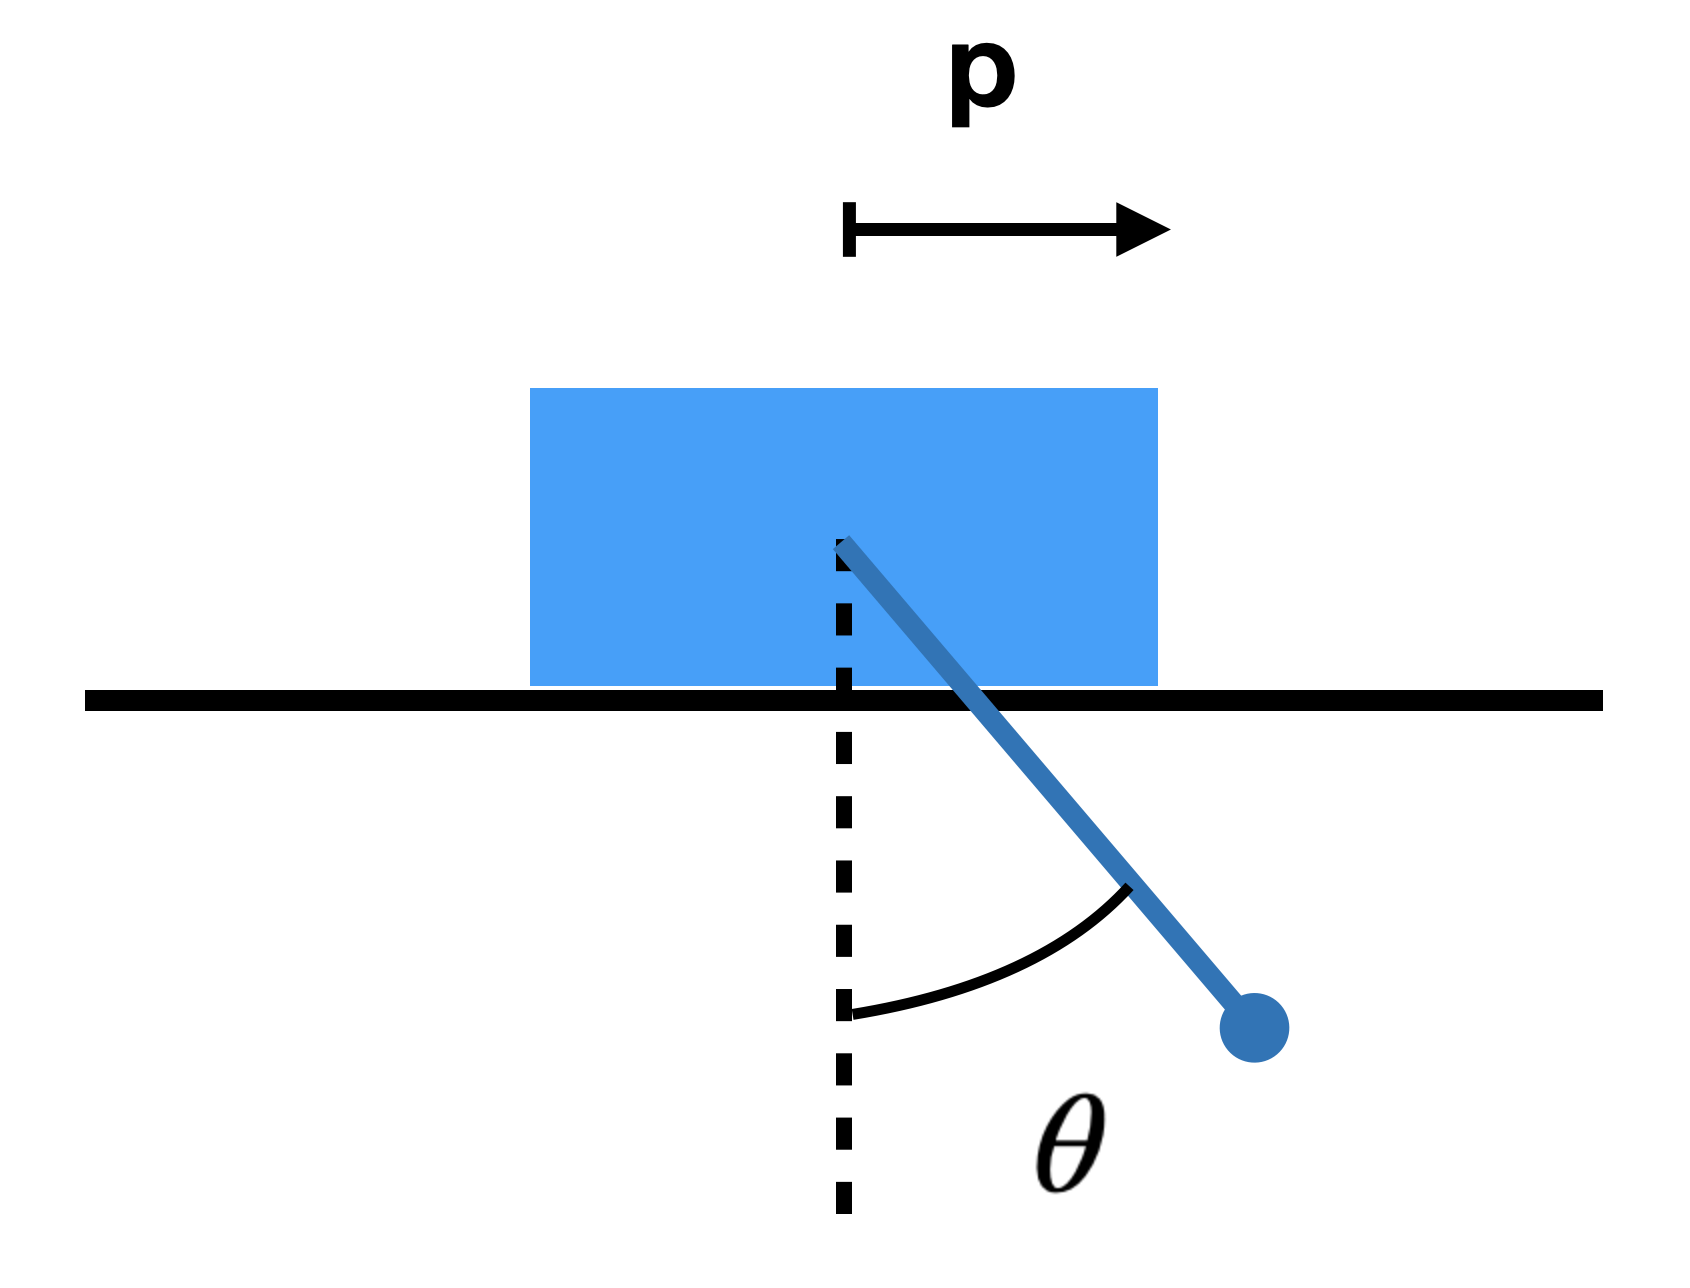
</div>
(if this image doesn't show up, check out `cartpole.png`)


with a cart position $p$ and pole angle $\theta$. We are first going to linearize the nonlinear discrete dynamics of this system about the point where $p = 0$, and $\theta = 0$ (no velocities), and use an infinite horizon LQR controller about this linearized state to stabilize the cartpole about this goal state.  The dynamics of the cartpole are parametrized by the mass of the cart, the mass of the pole, and the length of the pole. To simulate a "sim to real gap", we are going to design our controllers around an estimated set of problem parameters `params_est`, and simulate our system with a different set of problem parameters `params_real`. 

In [2]:
"""
continuous time dynamics for a cartpole, the state is 
x = [p, θ, ṗ, θ̇]
where p is the horizontal position, and θ is the angle
where θ = 0 has the pole hanging down, and θ = 180 is up.

The cartpole is parametrized by a cart mass `mc`, pole 
mass `mp`, and pole length `l`. These parameters are loaded 
into a `params::NamedTuple`. We are going to design the
controller for a estimated `params_est`, and simulate with 
`params_real`. 
"""
function dynamics(params::NamedTuple, x::Vector, u)
    # cartpole ODE, parametrized by params. 

    # cartpole physical parameters 
    mc, mp, l = params.mc, params.mp, params.l
    g = 9.81
    
    q = x[1:2]
    qd = x[3:4]

    s = sin(q[2])
    c = cos(q[2])

    H = [mc+mp mp*l*c; mp*l*c mp*l^2]
    C = [0 -mp*qd[2]*l*s; 0 0]
    G = [0, mp*g*l*s]
    B = [1, 0]

    qdd = -H\(C*qd + G - B*u[1])
    return [qd;qdd]

end

function rk4(params::NamedTuple, x::Vector,u,dt::Float64)
    # vanilla RK4
    k1 = dt*dynamics(params, x, u)
    k2 = dt*dynamics(params, x + k1/2, u)
    k3 = dt*dynamics(params, x + k2/2, u)
    k4 = dt*dynamics(params, x + k3, u)
    x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end

rk4 (generic function with 1 method)

## Part A: Infinite Horizon LQR about an equilibrium (10 pts)
Here we are going to solve for the infinite horizon LQR gain, and use it to stabilize the cartpole about the unstable equilibrium. 

In [3]:
@testset "LQR about eq" begin
    
    # states and control sizes 
    nx = 4 
    nu = 1 
    
    # desired x and g (linearize about these)
    xgoal = [0, pi, 0, 0]
    ugoal = [0]
    
    # initial condition (slightly off of our linearization point)
    x0 = [0, pi, 0, 0] + [1.5, deg2rad(-20), .3, 0]
    
    # simulation size 
    dt = 0.1 
    tf = 5.0 
    t_vec = 0:dt:tf
    N = length(t_vec)
    X = [zeros(nx) for i = 1:N]
    X[1] = x0 
    
    # estimated parameters (design our controller with these)
    params_est = (mc = 1.0, mp = 0.2, l = 0.5)
    
    # real paremeters (simulate our system with these)
    params_real = (mc = 1.2, mp = 0.16, l = 0.55)
    
    # TODO: solve for the infinite horizon LQR gain Kinf
    
    # cost terms 
    Q = diagm([1,1,.05,.1])
    Qf = 1*Q
    R = 0.1*diagm(ones(nu))
    
    #Find linearized A and B matrices
    u0 = zeros(nu)
    A = FD.jacobian(x_ -> dynamics(params_est, x_, ugoal), xgoal)
    B = FD.jacobian(u_ -> dynamics(params_est, xgoal, u_), ugoal)
        
    P = deepcopy(Qf)
    P_prev = deepcopy(P)
    K = zeros(nx, nu)
    for ricatti_iter = 1:1000
        K = (R+B'*P*B)\(B'*P*A)
        P = Q + K'*R*K + (A-B*K)'*P*(A - B*K)
        if norm(P - P_prev, 2) < 1e-5
            break
        end
        P_prev = P
    end

    Kinf = K
    
    # TODO: simulate this controlled system with rk4(params_real, ...)
    for i in 1:N-1
        x_tilde = (X[i] - xgoal)
        uk = ugoal - Kinf*x_tilde
        X[i+1] = X[i] - rk4(params_real, x_tilde, uk, dt)
    end
    
    # ---------------tests and plots/animations---------------
    @test X[1] == x0 
    @test norm(X[end])>0
    @test norm(X[end] - xgoal) < 0.1 
    
    Xm = hcat(X...)
    display(plot(t_vec,Xm',title = "cartpole",
                 xlabel = "time(s)", ylabel = "x",
                 label = ["p" "θ" "ṗ" "θ̇"]))
    
    # animation stuff
    display(animate_cartpole(X, dt))
    # ---------------tests and plots/animations---------------
end

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8700


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("pole" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "b" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x6d, 0x65, 0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x62], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "cart" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x63, 0x61, 0x72, 0x74], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "a" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x6d, 0x65, 0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x61], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{Any}(), ip"127.0.0.1", 8700))

Test Summary: | Pass  Total
LQR about eq  |    3      3


Test.DefaultTestSet("LQR about eq", Any[], 3, false, false)

## Part B: TVLQR for trajectory tracking (15 pts)

Here we are given a swingup trajectory that works for `params_est`, but will fail to work with `params_real`. To account for this sim to real gap, we are going to track this trajectory with a TVLQR controller. 

In [4]:
@testset "track swingup" begin 
    
    # optimized trajectory we are going to try and track
    DATA = load(joinpath(@__DIR__,"swingup.jld2"))
    Xbar = DATA["X"]
    Ubar = DATA["U"]
    
    # states and controls 
    nx = 4 
    nu = 1 
    
    # problem size 
    dt = 0.05 
    tf = 4.0 
    t_vec = 0:dt:tf
    N = length(t_vec)
    
    # states (initial condition of zeros)
    X = [zeros(nx) for i = 1:N]
    X[1] = [0, 0, 0, 0.0] 
    
    # make sure we have the same initial condition 
    @assert norm(X[1] - Xbar[1]) < 1e-12
    
    # real and estimated params 
    params_est = (mc = 1.0, mp = 0.2, l = 0.5)
    params_real = (mc = 1.2, mp = 0.16, l = 0.55)
    
    # TODO: design a time-varying LQR controller to track this trajectory 
    # use params_est for your control design, and params_real for the simulation
    
    # cost terms 
    Q = diagm([1,1,.05,.1])
    Qf = 10*Q
    R = 0.05*diagm(ones(nu))

    # TODO: solve for tvlqr gains K
    
    A = [zeros(nx,nx) for i = 1:N-1]
    B = [zeros(nx,nu) for i = 1:N-1]
    
    P = [zeros(nx,nx) for i = 1:N]
    P[N] = Qf
    K = [zeros(nx,nu) for i = 1:N-1]
    for k = (N-1):-1:1
        #Linearize system about current trajectory point
        A[k] = FD.jacobian(x_ -> dynamics(params_est, x_, Ubar[k]), Xbar[k])
        B[k] = FD.jacobian(u_ -> dynamics(params_est, Xbar[k], u_), Ubar[k])
        K[k] = (R+B[k]'*P[k+1]*B[k])\(B[k]'*P[k+1]*A[k])
        P[k] = Q + K[k]'*R*K[k] + (A[k]-B[k]*K[k])'*P[k+1]*(A[k]-B[k]*K[k])
    end
    
    
    # TODO: simulate this controlled system with rk4(params_real, ...)
    for i = 1:N-1
        x_tilde = (X[i] - Xbar[i])
        uk = Ubar[i] - K[i]*x_tilde
        X[i+1] = X[i] - rk4(params_real, x_tilde, uk, dt)
        
    end
    
    
    
    # ---------------tests and plots/animations---------------
    xn = X[N]
    @test norm(xn)>0
    @test 1e-6<norm(xn - Xbar[end])<.2
    @test abs(abs(rad2deg(xn[2])) - 180) < 5 # within 5 degrees 
    
    Xm = hcat(X...)
    Xbarm = hcat(Xbar...)
    plot(t_vec,Xbarm',ls=:dash, label = ["p̄" "θ̄" "ṗ̄" "θ̇̄"],lc = [:red :green :blue :black])
    display(plot!(t_vec,Xm',title = "Cartpole TVLQR (-- is reference)",
                 xlabel = "time(s)", ylabel = "x",
                 label = ["p" "θ" "ṗ" "θ̇"],lc = [:red :green :blue :black]))
    
    # animation stuff
    display(animate_cartpole(X, dt))
    # ---------------tests and plots/animations---------------

    
end

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8702


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("pole" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "b" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x6d, 0x65, 0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x62], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "cart" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x63, 0x61, 0x72, 0x74], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "a" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x6d, 0x65, 0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x61], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{Any}(), ip"127.0.0.1", 8702))

Test Summary: | Pass  Total
track swingup |    3      3


Test.DefaultTestSet("track swingup", Any[], 3, false, false)